# CNN-lytical Assignment-2
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   We will be using the same dataset as the previous assignment for MNIST. **Do not** use the complete MNIST dataset, even though PyTorch makes it really easy.

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [1]:
import numpy
from matplotlib import pyplot
import torch
import pickle
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Load *Dataset*
Use the pickle file shared for the previous assignment here.

In [2]:
# load the data set
with open('train_data.pkl','rb') as f:
    data = pickle.load(f)
X = data['X']
y = data['y']

# normalize the dataset, won't be doing it here in later assignments
normalized_data = numpy.zeros(X.shape)
normalized_data+= X-numpy.min(X,axis=0,keepdims=True)
max_data = numpy.max(X,axis=0,keepdims=True)
for i in range(max_data.shape[1]):
    if(max_data[0][i]==0):
        max_data[0][i] = 1
normalized_data /= max_data


# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library

X_train,X_test,y_train,y_test = train_test_split(normalized_data,y,stratify = y,test_size=0.8)

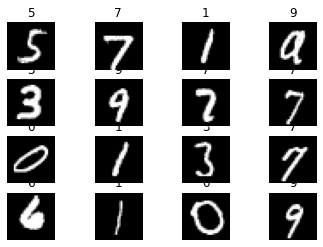

In [3]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
for i in range(1,17):
    pyplot.subplot(4,4,i)
    idx = random.randrange(0,60000)
    image = X[idx].reshape(28,28)
    pyplot.imshow(image,cmap = 'gray')
    pyplot.title(y[idx][0])
    pyplot.axis('off')
pyplot.show()

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


**Note** - Things like normalization, augmentation etc. which are related to the dataset are all done in this class. However, because this assignment doesn't deal with MNIST images but rather feature vectors, this part is being skipped here and will be discussed in Assignment 3.

In [4]:
# define your dataset class
class ImageDataSet(Dataset):
    def __init__(self):
        self.images = X_train
        self.image_labels = y_train
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        img = self.images[idx]
        label = self.image_labels[idx]
        return img,label

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [5]:
# define a child class of nn.Module for your model
# specify the architecture here itself
class Propagator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784,512)
        self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512,512)
        self.layer3 = nn.Linear(512,256)
        self.layer4 = nn.Linear(256,64)
        self.bn2 = nn.BatchNorm1d(64)
        self.layer5 = nn.Linear(64,64)
        self.final_layer = nn.Linear(64,10)
    def forward(self,x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.bn2(self.layer4(x)))
        x = F.relu(self.layer5(x))
        x = self.final_layer(x)
        x = F.log_softmax(x,dim=1)
        return x

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [6]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    n_epochs = 15
    for epoch in range(n_epochs):
        for x in train_loader:
            X_batch,y_batch = x
            output = model.forward(X_batch.float())
            optimizer.zero_grad()
            y_batch = torch.reshape(y_batch,(-1,))
            loss = criterion(output,y_batch)
            loss.backward()
            optimizer.step()
        if display_step and ( (epoch)%display_step == 0 or epoch == n_epochs-1):
            print(f"Loss After {epoch+1} epochs : {loss.item()}")

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [7]:
def init_weights():
    pass

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [8]:
def predict(model, X_test):
    X_test_ = torch.from_numpy(X_test).float()
    scores = model.forward(X_test_)
    np_scores = scores.detach().numpy()
    predictions = np_scores.argmax(axis = 1,keepdims = True)
    return predictions

In [9]:
def accuracy(pred, labels):
    total =0
    for x in range(pred.shape[0]):
        if(pred[x][0] == labels[x][0]):
            total += 1
    return 100*total/pred.shape[0]
    pass

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [10]:
model = Propagator()
criterion = nn.NLLLoss()
optimizer = optim.Adagrad(model.parameters())
train_data = ImageDataSet()
train_loader = DataLoader(train_data,batch_size = 128, shuffle = True)
train(model,optimizer,criterion,train_loader,display_step = 1)

Loss After 1 epochs : 0.17682485282421112
Loss After 2 epochs : 0.14980389177799225
Loss After 3 epochs : 0.07422339171171188
Loss After 4 epochs : 0.029716329649090767
Loss After 5 epochs : 0.024535343050956726
Loss After 6 epochs : 0.033616360276937485
Loss After 7 epochs : 0.028717001900076866
Loss After 8 epochs : 0.001712571713142097
Loss After 9 epochs : 0.008884485810995102
Loss After 10 epochs : 0.03458387777209282
Loss After 11 epochs : 0.0025073799770325422
Loss After 12 epochs : 0.0008541380520910025
Loss After 13 epochs : 0.0027910007629543543
Loss After 14 epochs : 0.013173623941838741
Loss After 15 epochs : 0.0039168852381408215


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [11]:
ans = predict(model,X_test)
print(f'Accuracy on test set: {accuracy(ans,y_test)}')

Accuracy on test set: 97.15625


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [12]:
torch.save(Propagator, 'ass_2.pt')

Check if it got saved right!

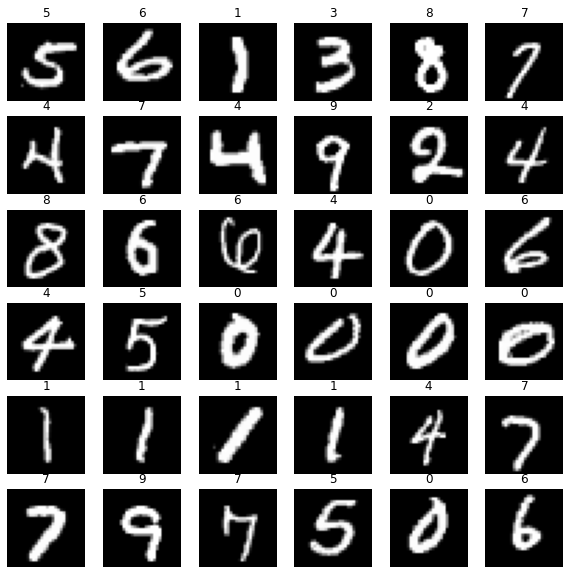

Accuracy for the test set = 97.72333333333333


In [13]:
# load the model, use predict function
final_model = torch.load('ass_2.pt')
with open('train_data.pkl','rb') as f:
    data = pickle.load(f)
X = data['X']
y = data['y']
predictions = predict(model,X)
pyplot.figure(figsize = (10,10))
for i in range(1,37):
    idx = random.randrange(X.shape[0])
    pyplot.subplot(6,6,i)
    pyplot.imshow(X[idx].reshape(28,28),cmap = 'gray')
    pyplot.axis('off')
    pyplot.title(predictions[idx][0])
pyplot.show()
print(f'Accuracy for the test set = {accuracy(predictions,y)}')